# Deep dive into a BSDF

## Overview

As you have probably already discovered, Mitsuba 3 can do much more than rendering. In this tutorial we will show how to instantiate a BSDF plugin using Python dictionaries and plot its distribution function using `matplotlib`.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>Instanciate Mitsuba objects using Python dict and mitsuba.load_dict</li>
  <li>Perform vectorized computations using a JIT variant of Mitsuba</li>
</ul>
    
</div>


## Setup

Of course, let's start with the usual Python imports! As emphasized in previous tutorials, Mitsuba requires a specific variant to be set before performing any other imports or computations. For this tutorial, we are going to use one of the JIT vectorized variant of the system. This will allow us to write code as if it was operating on normal scalar values, and have it run on arbitrary-sized arrays of values on the CPU or GPU.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Instantiating a BSDF

One easy way to instanciate Mitsuba objects (e.g., [<code>Shape</code>][1], [<code>BSDF</code>][2], ...) is using the [<code>load_dict</code>][3] function. This function takes as input a Python `dict` following a similar structure to the XML scene description and instantiates the corresponding plugin. You can learn more about the specific format of this `dict` by reading the dedicated section in the [documentation][4].

In this scenario, we want to construct a [roughconductor BSDF][5] with a high roughness value and a GGX microfacet distribution.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_shapes.html
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_bsdfs.html
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.load_dict
[4]: https://mitsuba.readthedocs.io/en/latest/src/key_topics/scene_format.html#scene-python-dict-format
[5]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_bsdfs.html#rough-conductor-material-roughconductor

In [2]:
bsdf = mi.load_dict({
    'type': 'roughconductor',
    'alpha': 0.2,
    'distribution': 'ggx'
})

## Vectorized evaluation of the BSDF

We will now evaluate this BSDF for a whole array of directions at once, leveraging the enabled vectorize backend. Similarly to working on `numpy` arrays, we use DrJit routines to perform array-based arithmetics.

For instance, here we start by defining a function to map from spherical and Euclidean coordinates.

In [3]:
def sph_to_dir(theta, phi):
    """Map spherical to Euclidean coordinates"""
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

We can then use this function to generate a set of directions to evaluate the BSDF with.

In [4]:
# Create a (dummy) surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with 45 degrees elevation
si.wi = sph_to_dir(dr.deg2rad(45.0), 0.0)

# Create grid in spherical coordinates and map it onto the sphere
res = 300
theta_o, phi_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_dir(theta_o, phi_o)

# Evaluate the whole array (18000 directions) at once
values = bsdf.eval(mi.BSDFContext(), si, wo)

## Plotting the results

Dr.Jit arrays of any flavour can easily be converted to an array type of other mainstream libraries, such as `numpy`, `PyTorch`, `JAX` and `TensorFlow`. For more detailed information on this, take a look at the extensive [drjit documentation][1].
In our case we are going to convert our drjit array to a numpy array.

[1]: https://drjit.readthedocs.io/en/master/

In [5]:
import numpy as np
values_np = np.array(values)

We can now use our favourite plotting library to visualize the BSDF distribution (here we use `matplotlib`).

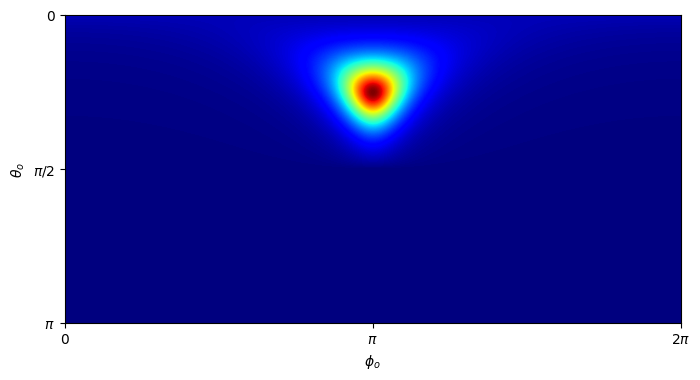

In [6]:
import matplotlib.pyplot as plt

# Extract red channel of BRDF values and reshape into 2D grid
values_r = values_np[0, :]
values_r = values_r.reshape(2 * res, res).T

# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))

im = ax.imshow(values_r, extent=[0, 2 * np.pi, np.pi, 0], cmap='jet')

ax.set_xlabel(r'$\phi_o$', size=10)
ax.set_xticks([0, dr.pi, dr.two_pi])
ax.set_xticklabels(['0', '$\\pi$', '$2\\pi$'])
ax.set_ylabel(r'$\theta_o$', size=10)
ax.set_yticks([0, dr.pi / 2, dr.pi])
ax.set_yticklabels(['0', '$\\pi/2$', '$\\pi$']);

## See also

- [<code>mitsuba.load_dict()</code>][1]
- [<code>mitsuba.BSDF.eval()</code>][2]

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.load_dict
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.BSDF.eval